In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls


import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

In [3]:
train_dir = "/kaggle/input/tomatoleaf/tomato/train/"
val_dir = "/kaggle/input/tomatoleaf/tomato/val/"

In [4]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [5]:
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [6]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [7]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [8]:
train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [9]:
test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 1000 images belonging to 10 classes.


In [10]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        
        id = np.random.randint(len(images))
#         img = images[id].numpy().astype('uint8')
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
    plt.show()
    

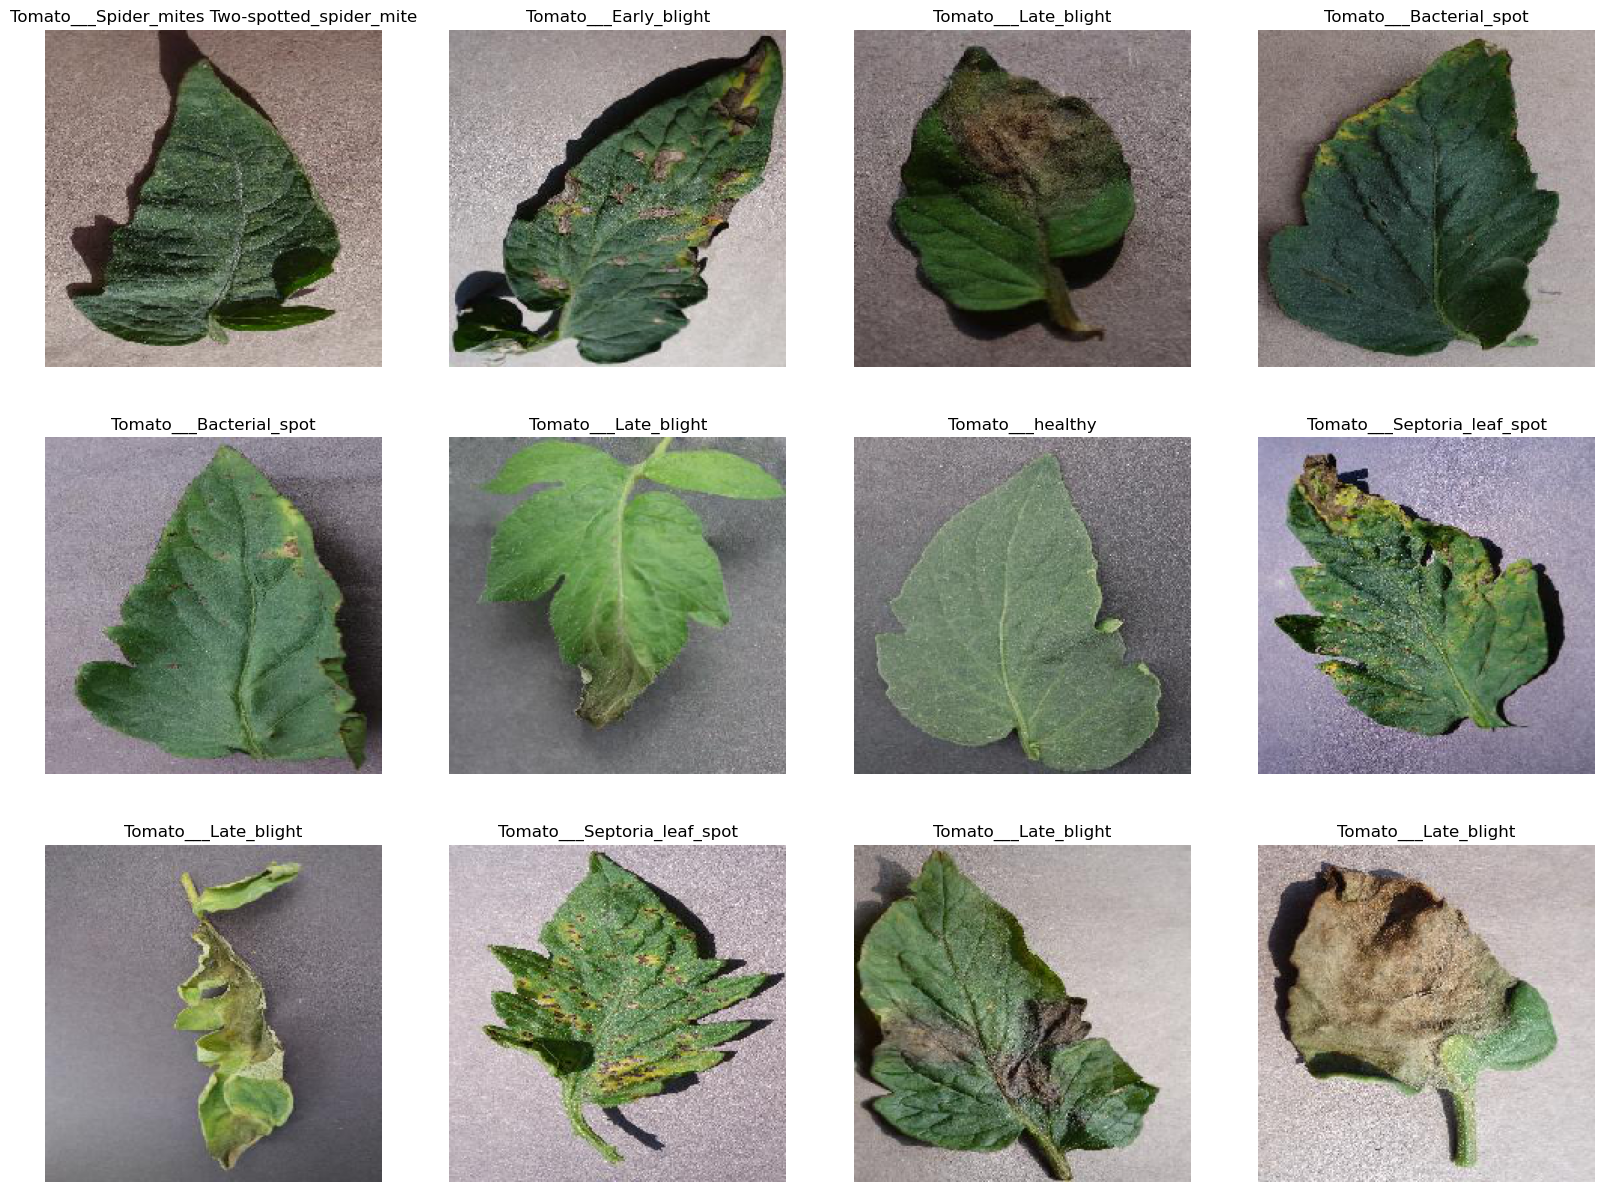

In [11]:
plot_images(train_ds, class_names)

In [12]:
def get_model():
    
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layers in base_model.layers:
        layers.trainable = False
        
    base_model_output = base_model.output
    
    x = Flatten()(base_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [13]:
model = get_model()

model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [14]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
250/250 [==============================] - 93s 329ms/step - loss: 1.8214 - accuracy: 0.5178 - val_loss: 0.9133 - val_accuracy: 0.6675
Epoch 2/10
250/250 [==============================] - 29s 116ms/step - loss: 0.6950 - accuracy: 0.7611 - val_loss: 0.5874 - val_accuracy: 0.7950
Epoch 3/10
250/250 [==============================] - 29s 116ms/step - loss: 0.4846 - accuracy: 0.8346 - val_loss: 0.8006 - val_accuracy: 0.7375
Epoch 4/10
250/250 [==============================] - 29s 114ms/step - loss: 0.3931 - accuracy: 0.8709 - val_loss: 0.5050 - val_accuracy: 0.8360
Epoch 5/10
250/250 [==============================] - 29s 116ms/step - loss: 0.2962 - accuracy: 0.9006 - val_loss: 0.4309 - val_accuracy: 0.8565
Epoch 6/10
250/250 [==============================] - 29s 116ms/step - loss: 0.1960 - accuracy: 0.9348 - val_loss: 0.6906 - val_accuracy: 0.7660
Epoch 7/10
250/250 [==============================] - 29s 114ms/step - loss: 0.1284 - accuracy: 0.9628 - val_loss: 0.4291 - val_ac

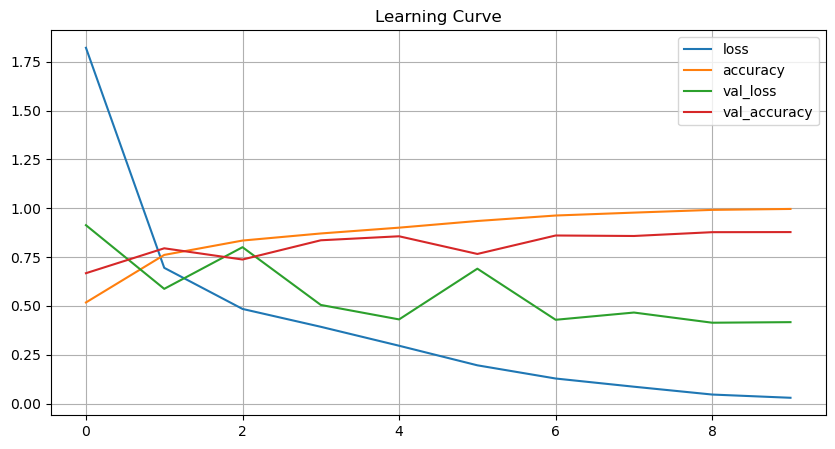

In [15]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()

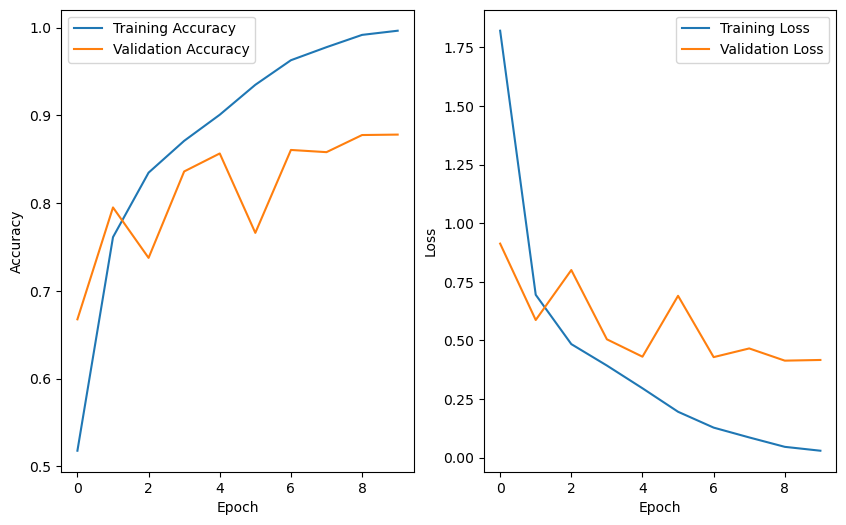

In [16]:
import matplotlib.pyplot as plt

# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy and loss over epochs
plt.figure(figsize=(10, 6))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
def predictImages(data, class_names, model):
    
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        
        i+=1
        if i > imgLen:
            break
            
    plt.show()

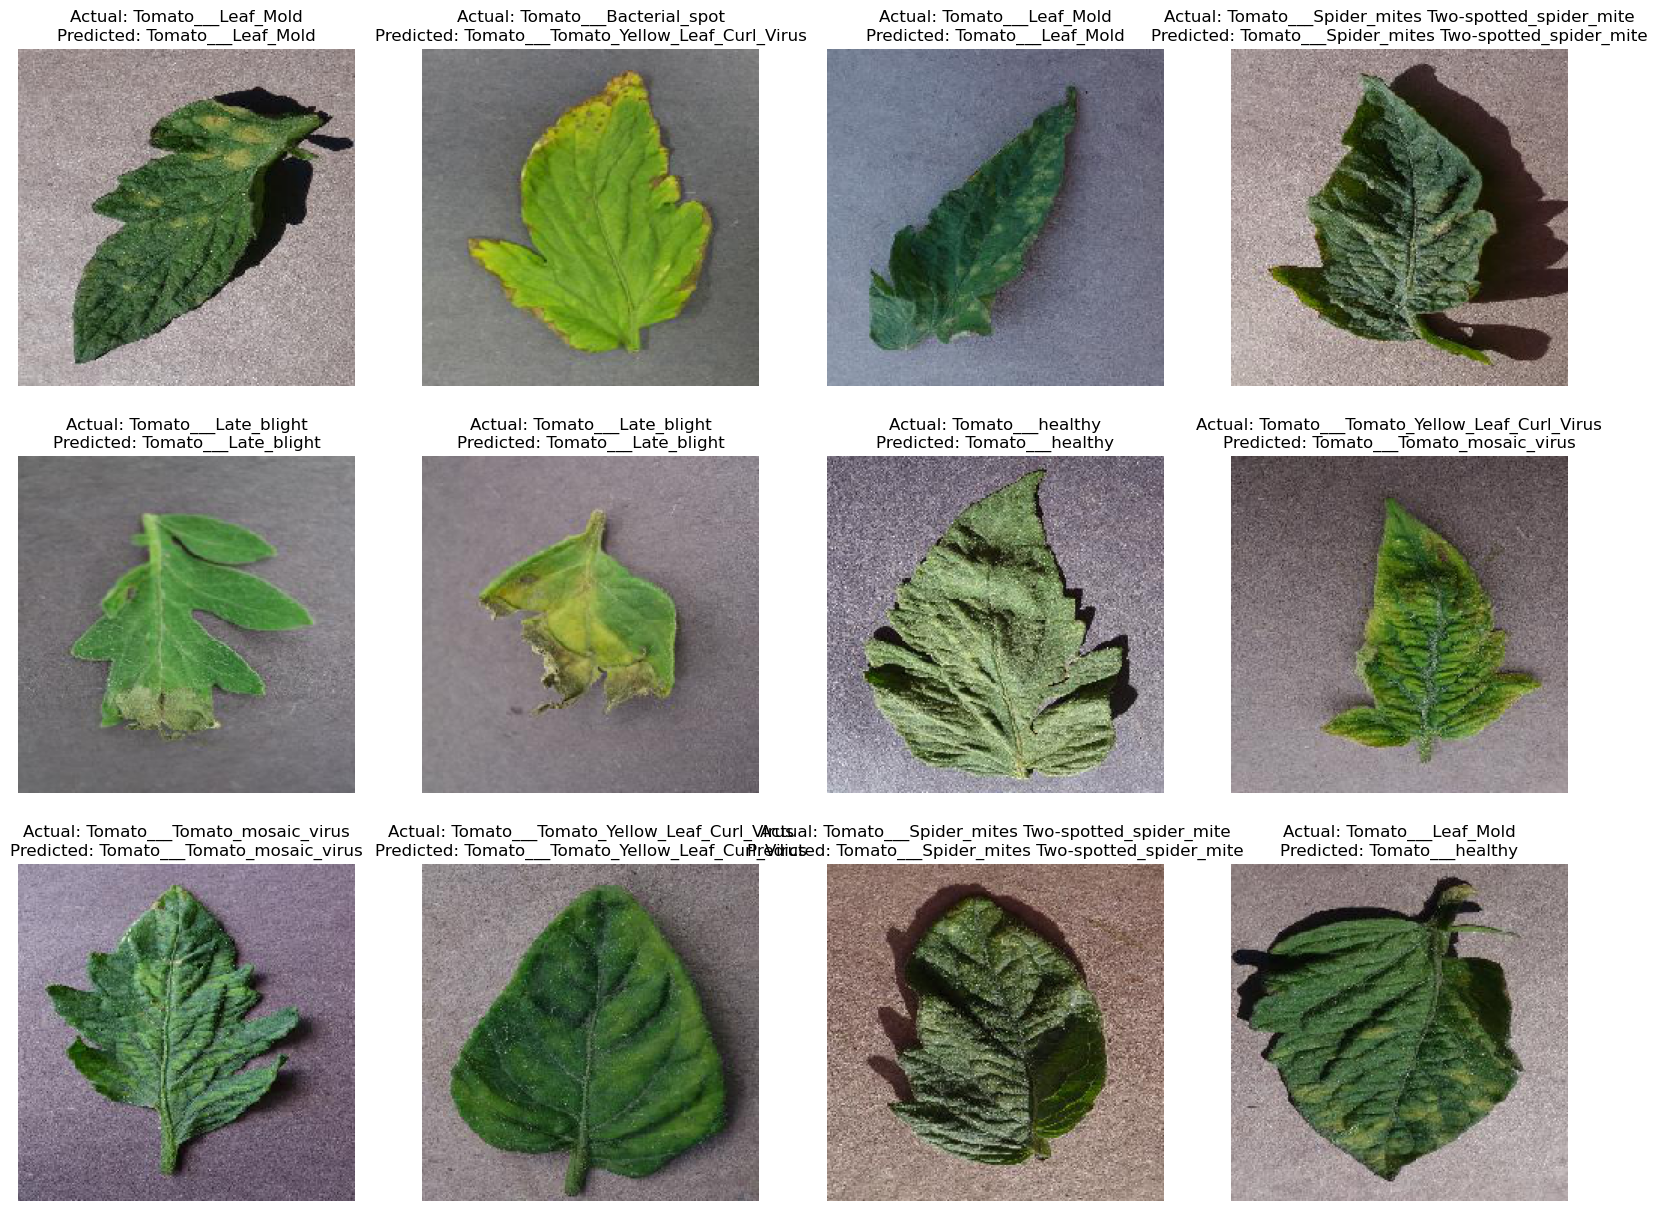

In [18]:
predictImages(test_ds, class_names, model)

In [19]:
model.save("model.h5")


In [20]:
import pickle

# Save model as pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [22]:
# Get predictions from the model on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=1)


32/32 [==============================] - 8s 220ms/step


In [23]:
y_pred.size

1000

In [24]:

# Get the true labels from the test dataset
y_true = test_ds.classes

In [25]:
y_true.size

1000

In [26]:
import matplotlib.pyplot as plt
import numpy as np  # Import NumPy if needed for array handling
from sklearn.metrics import confusion_matrix


# Calculate the confusion matrix
cm = confusion_matrix(y_true,y_pred,labels=None,sample_weight=None,normalize=None)


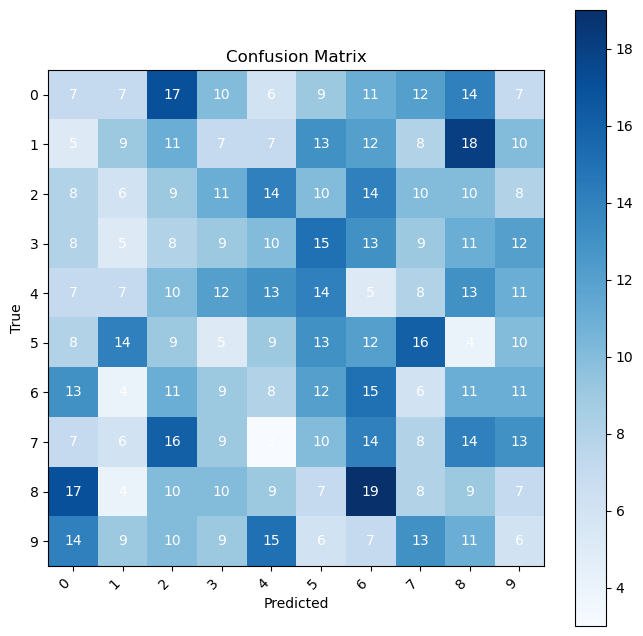

In [27]:

# Create a visually clear plot
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.imshow(cm, cmap='Blues')  # Use a colormap suitable for confusion matrices
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Add annotations for better readability
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > 0 else 'black')  # Ensure text visibility

plt.xticks(range(len(cm[0])), [label for label in set(y_true)], rotation=45, ha='right')  # Rotate x-axis labels for clarity
plt.yticks(range(len(cm[0])), [label for label in set(y_true)])

plt.show()
